In [39]:
from utils import * 
from algorithms import *
from agents import *

# parameters
disclosure = ['step'];
numStates = 6;
depth = 1

# game setup
numRounds, numPeriods, numSteps, numBuyers, numSellers, numTokens, gameTypes, seed = 500, 1, 16, 4, 4, 4, '1111', None
gameData = [gameTypes, numBuyers, numSellers, numTokens, numRounds, numPeriods, numSteps, seed]

# algo params
episodeLength = 16
numTrajectories = 10
gamma=0.99
std_init = 0.7
std_decay = 0.995
std_min = 0.05
lr = 0.0003
k = -0.15
p = 0.3

# agents
buyers = [
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=1, reinforcer=0),
         ]
sellers = [
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0),
           ZeroIntelligence(gameData, disclosure, index=0, buyer=0, reinforcer=0)
          ]

# logging
log = Log(gameData, disclosure,depth)
printInterval1, printInterval2, cnt, bprofits_history, sprofits_history, bidder_bids, bidder_profits = 100, 300, 0, [], [], [], []

# training loop
bprofits, sprofits = 0.0, 0.0
for rnd in range(numRounds):
    print(rnd, bprofits, sprofits)
    startRounds(gameData, log, buyers, sellers, rnd)
    bprofits, sprofits = 0.0, 0.0
    for period in range(numPeriods):
        startPeriods(buyers, sellers)
        for step in range(numSteps):

            # start step
            startSteps(buyers, sellers)

            # reset state
            for i in range(numBuyers):
                buyers[i].state = log.generateState(buyers[i], cnt, numStates)
                sellers[i].state = log.generateState(sellers[i], cnt, numStates)

            # bid-ask
            bids, asks = collectOffers(buyers, sellers)
            currentAsk, currentAskIdx, currentBid, currentBidIdx = bestOffers(bids, asks)
            price, buy, sell = trade(buyers, sellers, currentAsk, currentAskIdx, currentBid, currentBidIdx)

            # transact
            bprofit, sprofit = 0, 0
            if price > 0:
                buyers[currentBidIdx].transact(price)
                sellers[currentAskIdx].transact(price)
                bprofit = buyers[currentBidIdx].stepProfits
                sprofit = sellers[currentAskIdx].stepProfits

            # record
            bprofits += buyers[0].stepProfits
            sprofits += sellers[0].stepProfits
            log.addStep([rnd, period, step, currentBid, currentAsk,  buy, sell, price, price>0,
                         currentBidIdx==0, currentBidIdx==1, currentBidIdx==2, currentBidIdx==3, 
                         currentAskIdx==0, currentAskIdx==1, currentAskIdx==2, currentAskIdx==3, 
                         bids[0], bids[1], bids[2], bids[3], 
                         asks[0], asks[1], asks[2], asks[3], 
                         bprofit, sprofit])

            # end step
            observe(buyers, sellers, log.disclose())
            endSteps(buyers, sellers)

            # update state
            for i in range(numBuyers):
                buyers[i].newState = log.generateState(buyers[i], cnt, numStates)
                sellers[i].newState = log.generateState(sellers[i], cnt, numStates)

            # terminate period
            if step == numSteps - 1:
                for i in range(numBuyers):
                    buyers[i].done = True   
                    sellers[i].done = True                  
            else:
                for i in range(numBuyers):
                    buyers[i].done = False
                    sellers[i].done = False                  

            agentsObserve(buyers, sellers)
            agentsTrain(buyers, sellers)
            cnt+=1
        endPeriods(buyers, sellers)
    endRounds(buyers, sellers)

0 0.0 0.0
1 70.61419113980453 67.18747223198017
2 53.167585721798304 63.93750129979304
3 68.96713593718681 46.195962549298386
4 42.25558574024561 59.628997044751294
5 65.71108398586419 38.56244108888331
6 72.89964074401577 27.499316253565432
7 61.625358196274846 49.97335529368276
8 66.6747481556182 57.151275676630426
9 49.52742147163086 81.27610854498836
10 69.96821716374477 69.73527721307474
11 61.96276447387517 47.96739029791307
12 46.9290999982413 78.96669547838114
13 91.71401384461868 50.83004739504809
14 67.65001616390528 69.73488208610587
15 84.1653509940136 79.7519888204691
16 48.44245211374339 90.29160892610889
17 80.26997538002949 43.73919202091128
18 79.37483714898013 52.993893101406144
19 70.39855876244386 42.399272007043066
20 51.11720370010568 51.46919606398064
21 38.21160682324057 69.58104882545477
22 62.97699757452886 52.415246956356505
23 29.868451836810877 50.905432105941614
24 46.712010736377884 33.440205310342634
25 72.55334256431377 72.545206453889
26 42.75346018325

In [40]:
log.findCurrentTraders()

log.stepData['tprofit'] = log.stepData['bprofit'] + log.stepData['sprofit'] 
df = log.stepData[['tprofit','rnd']].groupby('rnd').sum()

print(df.mean(), df.std())

for i in range(4):
    var = 'bids_' + str(i)
    var2 = 'asks_' + str(i)
    log.stepData[var]=log.stepData[var].round(2)
    log.stepData[var2]=log.stepData[var2].round(2)

log.stepData['bids'] = log.stepData[['bids_0', 'bids_1', 'bids_2', 'bids_3']].apply(list, axis=1)
log.stepData['asks'] = log.stepData[['asks_0', 'asks_1', 'asks_2', 'asks_3']].apply(list, axis=1)

tprofit    474.888857
dtype: float64 tprofit    34.794642
dtype: float64


In [72]:
log.stepData.to_csv('zic_step.csv')
log.roundData.to_csv('zic_round.csv')

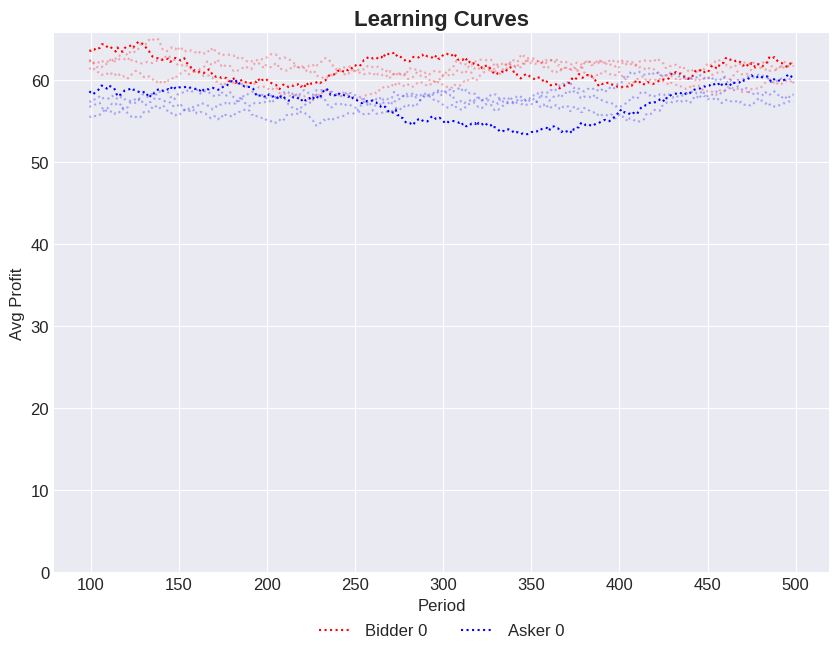

In [44]:
log.findCurrentTraders()
log.graphLearning(rolling_window = 100, trackBuyersIdx=[0], trackSellersIdx=[0], type = 'rnd')

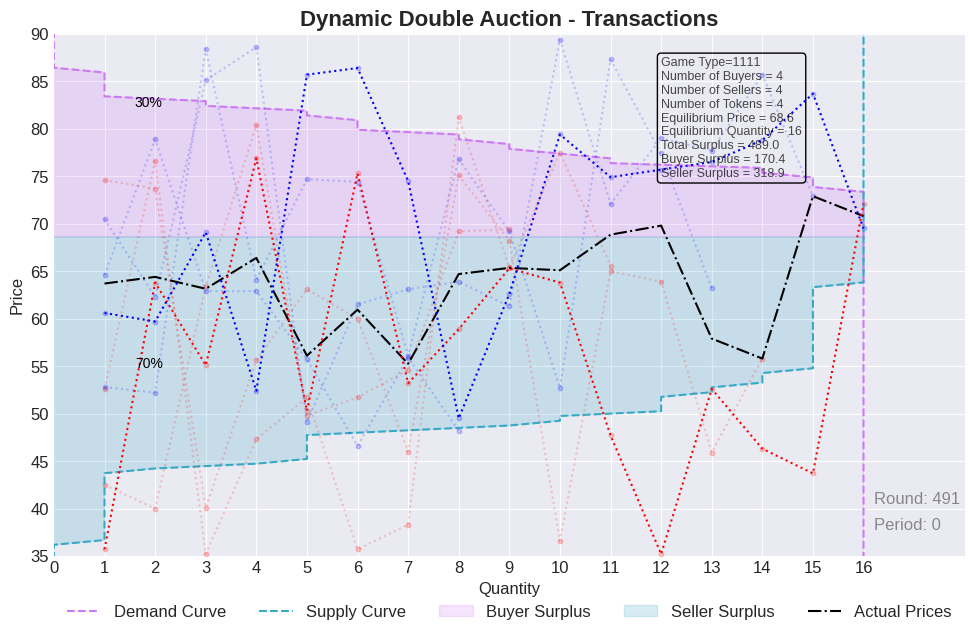

In [79]:
period = 1
log.graphSales(rnd-8, period-1, trackBuyersIdx=[0], trackSellersIdx=[0])

### Last 100 Rounds

In [46]:
df = log.stepData[log.stepData.rnd>(rnd-100)]
df_rnd = log.roundData[log.roundData.rnd>(rnd-100)]

In [47]:
df.columns

Index(['rnd', 'period', 'step', 'currentBid', 'currentAsk', 'buy', 'sell',
       'price', 'sale', 'currentBidIdx_0', 'currentBidIdx_1',
       'currentBidIdx_2', 'currentBidIdx_3', 'currentAskIdx_0',
       'currentAskIdx_1', 'currentAskIdx_2', 'currentAskIdx_3', 'bids_0',
       'bids_1', 'bids_2', 'bids_3', 'asks_0', 'asks_1', 'asks_2', 'asks_3',
       'bprofit', 'sprofit', 'currentBidIdx', 'currentAskIdx', 'tprofit',
       'bids', 'asks'],
      dtype='object')

### Efficiency

In [48]:
x = np.array(df.groupby('rnd').tprofit.sum().values)
y = np.array(df_rnd.totalSurplus)
df_rnd['EFF'] = x/y
df_rnd['EFF'].describe()

count    100.000000
mean       0.987756
std        0.017031
min        0.940270
25%        0.969990
50%        0.999499
75%        1.000167
max        1.001185
Name: EFF, dtype: float64

In [49]:
x = np.array(df.groupby('rnd').bprofit.sum().values)
y = np.array(df_rnd.buyerSurplus)
df_rnd['EFF'] = x/y
df_rnd['EFF'].describe()

count    100.000000
mean       1.029620
std        0.169278
min        0.740753
25%        0.925011
50%        1.009632
75%        1.134420
max        1.741338
Name: EFF, dtype: float64

In [50]:
x = np.array(df.groupby('rnd').sprofit.sum().values)
y = np.array(df_rnd.sellerSurplus)
df_rnd['EFF'] = x/y
df_rnd['EFF'].describe()

count    100.000000
mean       0.982641
std        0.163146
min        0.668517
25%        0.866162
50%        0.959129
75%        1.078291
max        1.381608
Name: EFF, dtype: float64

### Dispersion

In [69]:
x = df[['rnd', 'price']]
x.groupby('rnd').std().mean(), x.groupby('rnd').std().std()

(price    5.416655
 dtype: float64,
 price    0.988544
 dtype: float64)

In [51]:
x = df[['rnd', 'price']]
y = df_rnd[['rnd', 'peq']]
z = pd.merge(x, y, on='rnd')
z['dev'] = z['price'].sub(z['peq']).abs()
z.groupby('rnd').mean().mean()

price    64.754098
peq      65.120000
dev       4.635654
dtype: float64

In [53]:
z.groupby('rnd').mean().std()

price    1.428964
peq      2.286190
dev      0.965339
dtype: float64

In [66]:
autocorr_by_round = df.groupby('rnd')['price'].apply(lambda x: x.autocorr(lag=1))
x = pd.merge(df, autocorr_by_round.reset_index(name='autocorr'), on='rnd')
x.autocorr.mean(), x.autocorr.std()

(-0.03990276545884477, 0.24382995860713064)

### Switching

In [71]:
buyer_switch_mask = df['currentBidIdx'].ne(df['currentBidIdx'].shift())
seller_switch_mask = df['currentAskIdx'].ne(df['currentAskIdx'].shift())
buyer_switch_count = df.groupby('rnd')['period'].apply(lambda x: (buyer_switch_mask & (x == x.shift())).sum())
seller_switch_count = df.groupby('rnd')['period'].apply(lambda x: (seller_switch_mask & (x == x.shift())).sum())

print("Number of buyer switches within each round:")
print(np.mean(buyer_switch_count)/16)

print("\nNumber of seller switches within each round:")
print(np.mean(seller_switch_count)/16)

Number of buyer switches within each round:
0.72375

Number of seller switches within each round:
0.720625
